# LSTM for KOSPI Forecasting Example

In [1]:
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# to set data path
dataPath = 'https://raw.githubusercontent.com/stillxyxon/py_ml_analysis/master/'
# dataPath = 'C:/YONG/m1710/myPydata/'

# https://www.kaggle.com/amarpreetsingh/stock-prediction-lstm-using-keras/notebook 


# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

### Data Loading 

                 High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2020-11-27  2635.0000  2618.4700  2624.8000  2633.4500  1196000.0  2633.4500
2020-11-30  2648.6599  2591.3401  2648.0500  2591.3401  1311800.0  2591.3401
2020-12-01  2638.8701  2611.6699  2613.4199  2634.2500  1150300.0  2634.2500
2020-12-02  2677.2600  2644.5300  2645.8799  2675.8999  1076200.0  2675.8999
2020-12-03  2696.2200  2672.8501  2686.3799  2696.2200   817100.0  2696.2200
Close Median 2096.8150634765625
count    1448.0000
mean     2150.9040
std       191.6222
min      1457.6400
25%      2012.7849
50%      2096.8151
75%      2301.5850
max      2696.2200
Name: Close, dtype: float64
             High     Low    Open   Close  Volume  Adj Close
High       1.0000  0.3663  0.9987  0.9979  0.0444     0.9979
Low        0.3663  1.0000  0.3665  0.3681  0.0700     0.3681
Open       0.9987  0.3665  1.0000  0.9961  0.0317     0.9961
Close

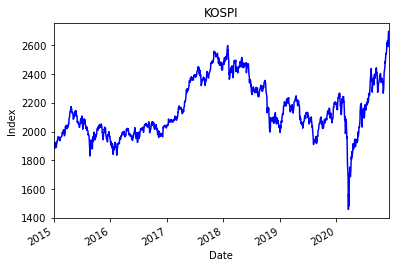

In [2]:
# reading in KOSPI history

import pandas_datareader as pdr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
 
pd.set_option('precision', 4)
 
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 12, 3)
df_null = pdr.DataReader("^KS11","yahoo",start,end)
df = df_null.dropna()
 
kospi_chart = df.Close.plot(style='b')
kospi_chart.set_title("KOSPI")
kospi_chart.set_ylabel("Index")
kospi_chart.set_xlim(str(start), str(end))
 
print(df.tail())
 
print("Close Median", df['Close'].median())
print(df['Close'].describe())
print(df.corr())
 
plt.show()


In [3]:
# set Close as taget to predict 

data = df[['Close']]
print(data.columns)
print(data.tail())

cl0 = data.Close

Index(['Close'], dtype='object')
                Close
Date                 
2020-11-27  2633.4500
2020-11-30  2591.3401
2020-12-01  2634.2500
2020-12-02  2675.8999
2020-12-03  2696.2200


KOSPI - 02-Jan-2015 ~ 03-Dec-2020


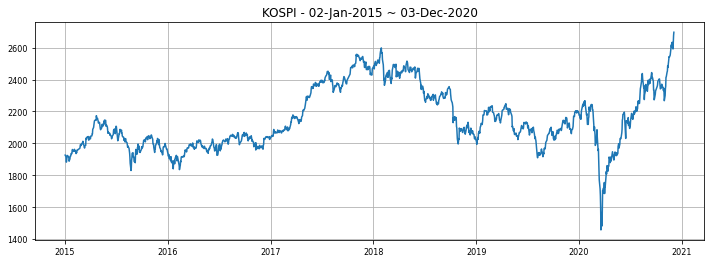

In [4]:
fromtimestampStr = cl0.index[0].strftime("%d-%b-%Y")
totimestampStr = cl0.index[len(cl0)-1].strftime("%d-%b-%Y")
periodText = 'KOSPI - ' + fromtimestampStr + ' ~ ' + totimestampStr

print(periodText)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0)
ax.grid()
plt.title(periodText)
ax.tick_params(axis='both', labelsize=8)
plt.show()

### Data Preparation

In [5]:
# get deviations from the previous day

print(cl0.head())
cl_startval = cl0[0]
print(cl_startval)

cl = cl0.subtract(cl0.shift(1))
cl_orgnl = cl.copy()[1:]

# to check outlier COVID-19?
# plt.hist(cl)
# plt.show()

cl = cl[1:]
print(len(cl))
print(cl.tail())
print(cl0.tail())

Date
2015-01-02    1926.4399
2015-01-05    1915.7500
2015-01-06    1882.4500
2015-01-07    1883.8300
2015-01-08    1904.6500
Name: Close, dtype: float64
1926.43994140625
1447
Date
2020-11-27     7.5400
2020-11-30   -42.1099
2020-12-01    42.9099
2020-12-02    41.6499
2020-12-03    20.3201
Name: Close, dtype: float64
Date
2020-11-27    2633.4500
2020-11-30    2591.3401
2020-12-01    2634.2500
2020-12-02    2675.8999
2020-12-03    2696.2200
Name: Close, dtype: float64


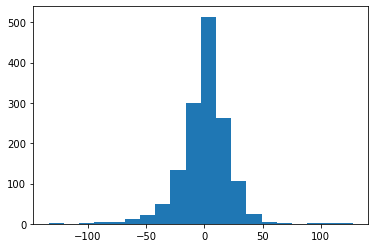

In [6]:
plt.hist(cl_orgnl, bins=20);

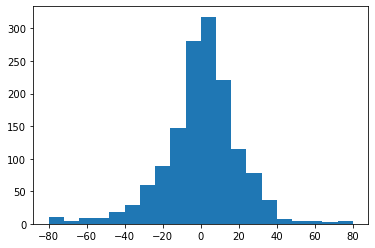

In [7]:
# adjust oultier
cl = np.where(cl>80,80,cl)
cl = np.where(cl<-80,-80,cl)

plt.hist(cl, bins=20);

[-10.68994141 -33.30004883   1.38000488  20.82006836  20.04992676
  -3.75        -3.80993652  -3.47998047   0.47998047 -26.01000977] 
 [0.43318787 0.29187469 0.50862503 0.63012543 0.62531204 0.4765625
 0.4761879  0.47825012 0.50299988 0.33743744]


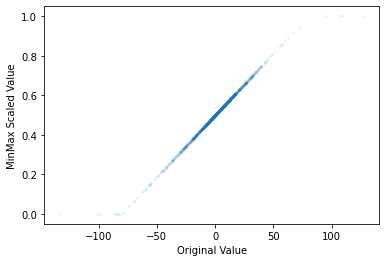

In [8]:
cl_train = cl[:(len(cl)-90)]

# Scale the data
clt_max, clt_min = cl_train.max(), cl_train.min()
# print(clt_max, clt_min)

cl = np.array(cl).reshape(cl.shape[0],1)
cl = (cl - clt_min) / (clt_max-clt_min)

# check values before and after scaling
print(np.array(cl_orgnl[:10]),'\n', cl.flatten()[:10])

# What is MinMax Scaling?

plt.scatter(cl_orgnl, cl.flatten(), alpha=0.05, s=5)
plt.xlabel('Original Value')
plt.ylabel('MinMax Scaled Value')
plt.show()


- scaler는 지정된 구간에서(train set) 기준값을 구해야함 
(후에 사용할 테스트 기간, 실제 운영시 새로운 데이터 투입 처리 용으로)
- 운영상황의 예측에서는 신규 데이터가 들어오며 (데이터 추가, 데이터셋 이동), 미래 장기간을 예측하는 경우라면 예측을 input으로 해서 예측을 계속하는 방안 밖에 없음

In [9]:
# a user function to process the data into 7 day look back(=lb) slices

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb = 10 # [5, 10, 15]  # lb = look back period in days
X,y = processData(cl,lb) 

# 최근 60개 일자의 값은 테스트용으로
# 테스트 이전 30개 값은 Validation 용으로 모델링중 사용

print(len(y), len(y)-60, len(y)-90)
a, b, c = len(y), len(y)-60, len(y)-90 
X_train, X_val, X_test = X[:c], X[c:b],X[b:]
y_train, y_val, y_test = y[:c], y[c:b],y[b:]

print('Train set :', X_train.shape[0], y_train.shape[0])
print('Validation set :', X_val.shape[0], y_val.shape[0])
print('Test set :', X_test.shape[0], y_test.shape[0])

print('\nTraining Set : \n', X_train[:2])
# slides one day

1436 1376 1346
Train set : 1346 1346
Validation set : 30 30
Test set : 60 60

Training Set : 
 [[0.43318787 0.29187469 0.50862503 0.63012543 0.62531204 0.4765625
  0.4761879  0.47825012 0.50299988 0.33743744]
 [0.29187469 0.50862503 0.63012543 0.62531204 0.4765625  0.4761879
  0.47825012 0.50299988 0.33743744 0.59056244]]


train Y mean =  0.5015353362946419


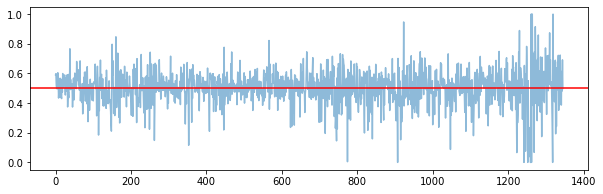

test Y mean =  0.5291666666666667


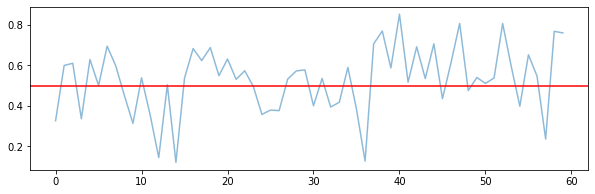

In [10]:
print('train Y mean = ',y_train.mean())
plt.figure(figsize=(10,3))
plt.plot(y_train, alpha=0.5)
plt.axhline(0.5, color='red')
plt.show()

print('test Y mean = ',y_test.mean())
plt.figure(figsize=(10,3))
plt.plot(y_test, alpha=0.5)
plt.axhline(0.5, color='red');

### Model Building

In [11]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# to adjust learning rate
from keras import optimizers 
optimizer = optimizers.Adam(lr=0.0000003)


# Build the model
model = Sequential()
model.add(LSTM(64,input_shape=(lb,1), return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(64, recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(optimizer=optimizer,loss='mean_squared_error') # loss = 'mae' or 'mean_squared_error'

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=200,
                    validation_data=(X_val,y_val),shuffle=True, batch_size = 10)


Epoch 1/200
135/135 [==============================] - 8s 56ms/step - loss: 0.2638 - val_loss: 0.3152
Epoch 2/200
135/135 [==============================] - 5s 38ms/step - loss: 0.2623 - val_loss: 0.3135
Epoch 3/200
135/135 [==============================] - 5s 38ms/step - loss: 0.2608 - val_loss: 0.3118
Epoch 4/200
135/135 [==============================] - ETA: 0s - loss: 0.259 - 5s 36ms/step - loss: 0.2592 - val_loss: 0.3102
Epoch 5/200
135/135 [==============================] - 5s 37ms/step - loss: 0.2577 - val_loss: 0.3085
Epoch 6/200
135/135 [==============================] - 5s 36ms/step - loss: 0.2562 - val_loss: 0.3068
Epoch 7/200
135/135 [==============================] - ETA: 0s - loss: 0.254 - 5s 37ms/step - loss: 0.2547 - val_loss: 0.3052
Epoch 8/200
135/135 [==============================] - 5s 37ms/step - loss: 0.2531 - val_loss: 0.3035
Epoch 9/200
135/135 [==============================] - 5s 38ms/step - loss: 0.2517 - val_loss: 0.3019
Epoch 10/200
135/135 [============

135/135 [==============================] - 4s 33ms/step - loss: 0.1206 - val_loss: 0.1563
Epoch 81/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1184 - val_loss: 0.1539
Epoch 82/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1162 - val_loss: 0.1514
Epoch 83/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1140 - val_loss: 0.1490
Epoch 84/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1118 - val_loss: 0.1465
Epoch 85/200
135/135 [==============================] - 4s 32ms/step - loss: 0.1097 - val_loss: 0.1441
Epoch 86/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1074 - val_loss: 0.1416
Epoch 87/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1053 - val_loss: 0.1392
Epoch 88/200
135/135 [==============================] - 4s 33ms/step - loss: 0.1032 - val_loss: 0.1367
Epoch 89/200
135/135 [==============================] - 5s 35ms/step - loss: 0.1009 - 

135/135 [==============================] - 5s 34ms/step - loss: 0.0157 - val_loss: 0.0349
Epoch 160/200
135/135 [==============================] - 4s 33ms/step - loss: 0.0155 - val_loss: 0.0348
Epoch 161/200
135/135 [==============================] - 5s 34ms/step - loss: 0.0156 - val_loss: 0.0348
Epoch 162/200
135/135 [==============================] - 5s 36ms/step - loss: 0.0157 - val_loss: 0.0348
Epoch 163/200
135/135 [==============================] - 4s 33ms/step - loss: 0.0156 - val_loss: 0.0347
Epoch 164/200
135/135 [==============================] - 5s 34ms/step - loss: 0.0156 - val_loss: 0.0347
Epoch 165/200
135/135 [==============================] - 5s 36ms/step - loss: 0.0156 - val_loss: 0.0347
Epoch 166/200
135/135 [==============================] - 5s 34ms/step - loss: 0.0156 - val_loss: 0.0347
Epoch 167/200
135/135 [==============================] - 5s 34ms/step - loss: 0.0156 - val_loss: 0.0347
Epoch 168/200
135/135 [==============================] - 4s 33ms/step - loss: 

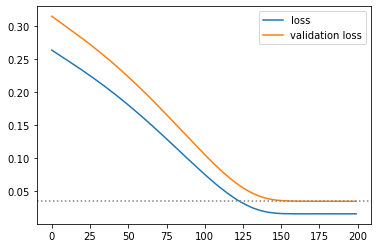

min 1% loss (loss, val_loss) :  0.015516082337126137 0.03458286456763745
mean of last 10 losses (loss, val_loss) :  0.01555665461346507 0.03458968438208103


In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'validation loss'], loc='upper right')
plt.axhline(np.percentile(history.history['val_loss'],5), color='grey',
           linestyle=':')
plt.show()

# 작은순 1% loss 지점은? - 일회성의 큰 변동을 무시하기 위한 방안
print('min 1% loss (loss, val_loss) : ', np.percentile(history.history['loss'],1), np.percentile(history.history['val_loss'],1))
# 마지막 10개 epoch의 loss 평균값은?
print('mean of last 10 losses (loss, val_loss) : ', np.mean(history.history['loss'][-10:]), np.mean(history.history['val_loss'][-10:]))

### Assessment of LSTM Predictions

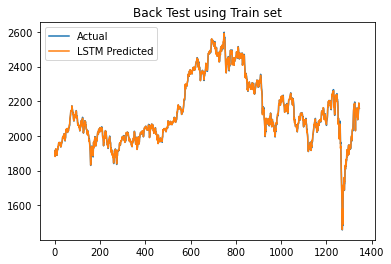

MAE :  3.0885161106512062


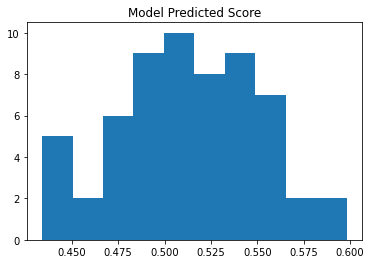

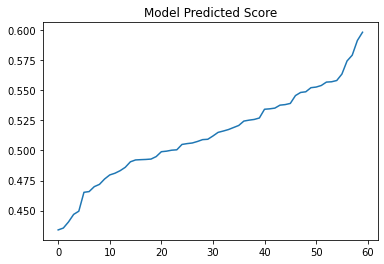

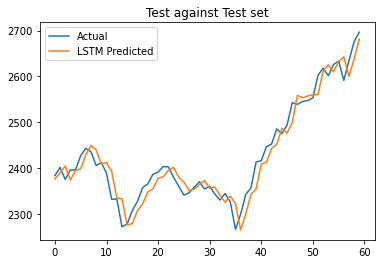

MAE :  21.50665143330892


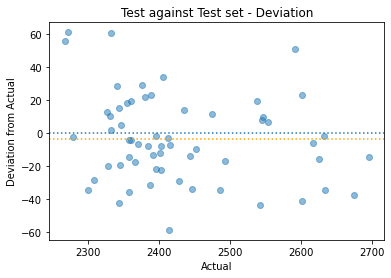

In [13]:
# 예측과 실제를 비교하는 챠트를 생성하는 함수
# 데이터셋을 변경하는 경우에도 재사용

def PredActPlot(x, y, title):
    y = list(cl0[:(len(y)+1)])
    plt.plot(y[1:])
    Xt = model.predict(x)
    Xt = (Xt * (clt_max-clt_min)) + clt_min
    Xt = y[1:] + Xt.reshape(-1,)
    plt.plot(Xt)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(y[1:] - Xt).mean())
    

PredActPlot(X_train, y_train, 'Back Test using Train set')    


test_prev = list(cl0[-(60+1):])[:60]  
test_actual = list(cl0[-(60):])
Xt = model.predict(X_test).reshape(-1,)
Xta = Xt.reshape(-1,)
# reverse scale
Xt = (Xt * (clt_max-clt_min)) + clt_min
test_predicted = test_prev + Xt


plt.hist(Xta)
plt.title('Model Predicted Score')
plt.show()

plt.plot(np.sort(Xta))
plt.title('Model Predicted Score')
plt.show()


# 데이터셋을 변경하는 경우에도 재사용 고려해서 함수화

def PredActPlot(x, y, title, dstype):
    plt.plot(test_actual)
    plt.plot(test_predicted)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(test_predicted - test_actual).mean())
    
    
PredActPlot(X_test, y_test, 'Test against Test set', 'test')   

def PredActDevPlot(x, y, title):    
    plt.scatter(test_actual, test_predicted - test_actual, alpha=0.5)
    plt.axhline(0, linestyle=':')
    plt.axhline(np.mean(test_predicted - test_actual), linestyle=':',
               color='orange')
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Deviation from Actual')
    plt.show()
     
PredActDevPlot(X_test, y_test, 'Test against Test set - Deviation')       

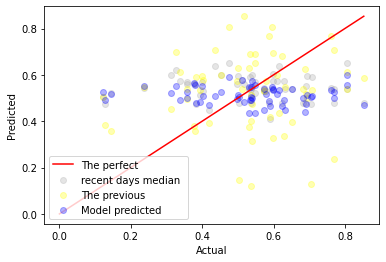

correlation between actual and the previous :  0.07656934037349461
correlation between actual and recent days median :  -0.02874781095874084
correlation between actual and model predicted :  -0.08070749978445974


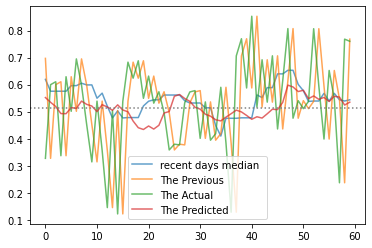

MAE of the previous :  20.879829915364585
MAE of the recent days median :  21.09549763997396
MAE of the predicted :  21.50665143330892


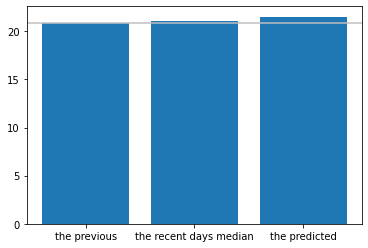

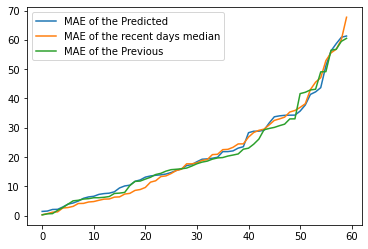

In [14]:
# a scatter plot of median of past 7 days and the target?
# a scatter plot of the previous day and the target?

X_prv = X_test[:,X_test.shape[1]-1,:].reshape(-1,)

plt.scatter(y_test, np.median(X_test, axis=1), alpha=0.3, color='darkgrey')
plt.scatter(y_test, X_prv, alpha=0.3, color='yellow')
plt.scatter(y_test, Xta, alpha=0.3, color='blue')
plt.plot([0,y_test.max()],[0,y_test.max()], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(['The perfect','recent days median ','The previous', 'Model predicted'])
plt.show()


print('correlation between actual and the previous : ', np.corrcoef(y_test, X_prv)[0,1])
print('correlation between actual and recent days median : ', np.corrcoef(y_test, np.median(X_test, axis=1).flatten())[0,1])
print('correlation between actual and model predicted : ', np.corrcoef(y_test, Xta)[0,1])


plt.plot(np.median(X_test, axis=1), alpha=0.7)
plt.plot(X_prv, alpha=0.7)
plt.plot(y_test, alpha=0.7)
plt.plot(Xta, alpha=0.7)
plt.legend(['recent days median ','The Previous', 'The Actual', 'The Predicted'])
plt.axhline(Xta.mean(), color='grey', linestyle=":")
plt.show()

test_med_pst = (np.median(X_test, axis=1).reshape(-1) * (clt_max-clt_min)) + clt_min  + test_prev 

print('MAE of the previous : ', abs(np.array(test_prev)  - np.array(test_actual)).mean()) 
print('MAE of the recent days median : ', abs(np.array(test_med_pst) - np.array(test_actual)).mean())
print('MAE of the predicted : ', abs(test_predicted - test_actual).mean())

ErrorList = np.array([abs(np.array(test_prev)  - np.array(test_actual)).mean(), abs(np.array(test_med_pst) - np.array(test_actual)).mean(), abs(test_predicted - test_actual).mean()])
plt.bar(['the previous','the recent days median','the predicted'], ErrorList)
plt.axhline(ErrorList.min(), color='silver')
plt.show()

plt.plot(np.sort(abs(test_predicted - test_actual)))
plt.plot(np.sort(abs(np.array(test_med_pst)  - np.array(test_actual))))
plt.plot(np.sort(abs(np.array(test_prev)  - np.array(test_actual))))
plt.legend(['MAE of the Predicted', 'MAE of the recent days median', 'MAE of the Previous'])
plt.show()

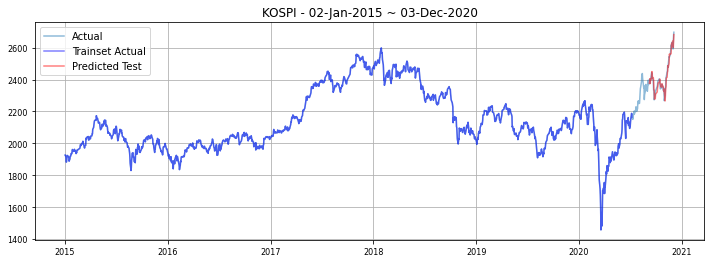

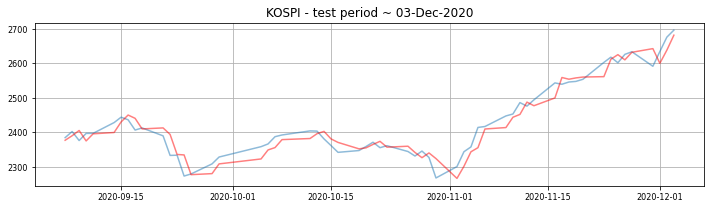

In [15]:
clpred = cl0[-60:].copy()
clpred.loc[:] = test_predicted

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0, alpha=0.5)
ax.plot(cl0[:(len(y_train))], color='blue', alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
plt.title(periodText)
ax.tick_params(axis='both', labelsize=8)
plt.legend(['Actual','Trainset Actual', 'Predicted Test'])
plt.show()


fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(cl0[-60:], alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
titleText = 'KOSPI - test period ~ ' + totimestampStr
plt.title(titleText )
ax.tick_params(axis='both', labelsize=8)
plt.show()




[예측결과 종합]
- 전날 값 (최근) 의 영향을 받을 수 밖에 없기에 이미 전날 값을 뒤따라가는 패턴과 유사하게 예측하는 모습
- 자기 시계열만으로는 전날 값으로부터의 변화를 많이 설명하지 못함
- 하지만, 전날값이 불변한다고 가정하는 것에 비해서는 미세하게 오차 적음
- 값 자체에 대한 예측에서는 전날을 이기지 못한 것에 비해서는 전날로부터의 변화를 예측하는 방식으로 오차 감소